In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/ibtracs_dataset.csv')

In [3]:
features = [
  'LAT', 'LON',
  'DIST2LAND', 'LANDFALL',
  'STORM DIR', 'STORM SPEED',
  'MOVE X', 'MOVE Y', 'ACCELERATION', 'TURN RATE',
  'LAT LAG 1', 'LON LAG 1', 'SPEED LAG 1', 'DIR LAG 1',
  'LAT LAG 2', 'LON LAG 2', 'SPEED LAG 2', 'DIR LAG 2',
  'LAT LAG 3', 'LON LAG 3', 'SPEED LAG 3', 'DIR LAG 3',
  'LAT CHANGE', 'LON CHANGE', 'DISTANCE', 'REAL SPEED',
  'DIST EQUATOR', 'NORTH HEMISPHERE', 'NEAR LAND', 'STORM SPEED NEAR LAND',
  'SPEED MEAN 3', 'DIR STD 3',
  'SPEED MEAN 6', 'DIR STD 6',
  'MONTH', 'HOUR', 'DAY OF YEAR', 'TIME FROM GENESIS'
]

encoded_features = [
  'BASIN_EP', 'BASIN_NI', 'BASIN_WP',
  'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS', 'NATURE_TS'
]

features.extend(encoded_features)

## LATITUDE MODELS

In [4]:
def train_latitude_models(X_train, X_test, y_train, y_test, horizons):
  lat_models = {}
  lat_results = {}

  for horizon in horizons:
    pipeline = Pipeline([
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler()),
      ('poly', PolynomialFeatures(degree=2, include_bias=False)),
      ('model', Ridge(alpha=1.0))
    ])

    y_train_horizon = y_train[f'LAT_{horizon}']
    y_test_horizon = y_test[f'LAT_{horizon}']

    train_mask = y_train_horizon.notna()
    test_mask = y_test_horizon.notna()
    
    X_train_clean = X_train[train_mask]
    y_train_clean = y_train_horizon[train_mask]
    X_test_clean = X_test[test_mask]
    y_test_clean = y_test_horizon[test_mask]

    pipeline.fit(X_train_clean, y_train_clean)

    y_pred = pipeline.predict(X_test_clean)

    # Metrics
    mse = mean_squared_error(y_test_clean, y_pred)
    mae = mean_absolute_error(y_test_clean, y_pred)
    r2 = r2_score(y_test_clean, y_pred)
    rmse = np.sqrt(mse)

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train_clean, y_train_clean, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    lat_models[horizon] = pipeline
    lat_results[horizon] = {
      'predictions': y_pred,
      'mse': mse,
      'mae': mae,
      'r2': r2,
      'rmse': rmse,
      'cv_rmse': cv_rmse,
      'test_actual': y_test_clean.values
    }
        
    print(f'LAT {horizon} - RMSE: {rmse:.4f}, R²: {r2:.4f}, CV_RMSE: {cv_rmse:.4f}')
    print(f'Samples: Train={len(X_train_clean)}, Test={len(X_test_clean)}')

  return lat_models, lat_results

## LONGTITUDE MODELS

In [5]:
def train_longitude_models(X_train, X_test, y_train, y_test, horizons):
  lon_models = {}
  lon_results = {}

  for horizon in horizons:
    pipeline = Pipeline([
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler()),
      ('poly', PolynomialFeatures(degree=2, include_bias=False)),
      ('model', Ridge(alpha=1.0))
    ])

    y_train_horizon = y_train[f'LON_{horizon}']
    y_test_horizon = y_test[f'LON_{horizon}']

    train_mask = y_train_horizon.notna()
    test_mask = y_test_horizon.notna()
    
    X_train_clean = X_train[train_mask]
    y_train_clean = y_train_horizon[train_mask]
    X_test_clean = X_test[test_mask]
    y_test_clean = y_test_horizon[test_mask]

    pipeline.fit(X_train_clean, y_train_clean)

    y_pred = pipeline.predict(X_test_clean)

    # Metrics
    mse = mean_squared_error(y_test_clean, y_pred)
    mae = mean_absolute_error(y_test_clean, y_pred)
    r2 = r2_score(y_test_clean, y_pred)
    rmse = np.sqrt(mse)

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train_clean, y_train_clean, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    lon_models[horizon] = pipeline
    lon_results[horizon] = {
      'predictions': y_pred,
      'mse': mse,
      'mae': mae,
      'r2': r2,
      'rmse': rmse,
      'cv_rmse': cv_rmse,
      'test_actual': y_test_clean.values
    }

    print(f'LON {horizon} - RMSE: {rmse:.4f}, R²: {r2:.4f}, CV_RMSE: {cv_rmse:.4f}')
    print(f'Samples: Train={len(X_train_clean)}, Test={len(X_test_clean)}')
    
  return lon_models, lon_results

## PREPARE TRAINING DATA

In [6]:
X = df[features].copy()

horizons = ['6H', '12H', '24H']
y_lat = {}
y_lon = {}

for horizon in horizons:
  y_lat[f'LAT_{horizon}'] = df[f'NEXT LAT {horizon}']
  y_lon[f'LON_{horizon}'] = df[f'NEXT LON {horizon}']

y_lat_df = pd.DataFrame(y_lat)
y_lon_df = pd.DataFrame(y_lon)

In [7]:
X_train, X_test, y_lat_train, y_lat_test = train_test_split(
  X, y_lat_df, test_size=0.2, random_state=42, shuffle=True
)

_, _, y_lon_train, y_lon_test = train_test_split(
  X, y_lon_df, test_size=0.2, random_state=42, shuffle=True
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Training set: 77136 samples
Test set: 19284 samples


## TRAIN MODELS

In [8]:
lat_models, lat_results = train_latitude_models(X_train, X_test, y_lat_train, y_lat_test, horizons)
lon_models, lon_results = train_longitude_models(X_train, X_test, y_lon_train, y_lon_test, horizons)

LAT 6H - RMSE: 0.1273, R²: 0.9998, CV_RMSE: 0.1321
Samples: Train=77136, Test=19284
LAT 12H - RMSE: 0.4058, R²: 0.9984, CV_RMSE: 0.4072
Samples: Train=77136, Test=19284
LAT 24H - RMSE: 1.1149, R²: 0.9894, CV_RMSE: 1.1110
Samples: Train=77136, Test=19284
LON 6H - RMSE: 0.1560, R²: 0.9999, CV_RMSE: 0.1865
Samples: Train=77136, Test=19284
LON 12H - RMSE: 0.5206, R²: 0.9991, CV_RMSE: 0.5310
Samples: Train=77136, Test=19284
LON 24H - RMSE: 1.5295, R²: 0.9930, CV_RMSE: 1.5290
Samples: Train=77136, Test=19284


## COMBINE PREDICTIONS AND CALCULATE DISTANCE ERROR

In [9]:
def calculate_distance_errors(lat_results, lon_results, horizons):
  distance_errors = {}

  for horizon in horizons:
    lat_pred = lat_results[horizon]['predictions']
    lon_pred = lon_results[horizon]['predictions']
    lat_actual = lat_results[horizon]['test_actual']
    lon_actual = lon_results[horizon]['test_actual']

    def haversine(lat1, lon1, lat2, lon2):
      R = 6371  # Earth radius in km
      lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
      dlat = lat2 - lat1
      dlon = lon2 - lon1
      a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
      return 2 * R * np.arcsin(np.sqrt(a))
    
    distances = []
    for i in range(len(lat_actual)):
      dist = haversine(lat_actual[i], lon_actual[i], lat_pred[i], lon_pred[i])
      distances.append(dist)
    
    distances = np.array(distances)

    distance_errors[horizon] = {
      'mean_km': np.mean(distances),
      'std_km': np.std(distances),
      'max_km': np.max(distances),
      'median_km': np.median(distances),
      'q95_km': np.percentile(distances, 95)
    }

    print(f'\n{horizon} Prediction:')
    print(f'Mean Distance Error: {distance_errors[horizon]['mean_km']:.2f} km')
    print(f'Std Distance Error: {distance_errors[horizon]['std_km']:.2f} km')
    print(f'Max Distance Error: {distance_errors[horizon]['max_km']:.2f} km')
    print(f'95th Percentile: {distance_errors[horizon]['q95_km']:.2f} km')

  return distance_errors

In [10]:
distance_errors = calculate_distance_errors(lat_results, lon_results, horizons)


6H Prediction:
Mean Distance Error: 15.29 km
Std Distance Error: 13.67 km
Max Distance Error: 355.14 km
95th Percentile: 36.50 km

12H Prediction:
Mean Distance Error: 50.60 km
Std Distance Error: 42.92 km
Max Distance Error: 808.07 km
95th Percentile: 127.83 km

24H Prediction:
Mean Distance Error: 149.71 km
Std Distance Error: 114.41 km
Max Distance Error: 1748.47 km
95th Percentile: 370.56 km


## VISUALIZATION - PREDICTIONS VS ACTUAL

In [11]:
def plot_predictions_comparison(lat_results, lon_results, horizons):
  fig, axes = plt.subplots(2, 3, figsize=(18, 12))
  fig.suptitle('PREDICTIONS VS ACTUAL - SEPARATE LATITUDE & LONGITUDE MODELS', fontsize=16, fontweight='bold')

  for i, horizon in enumerate(horizons):
    # Latitude plots
    ax_lat = axes[0, i]
    lat_pred = lat_results[horizon]['predictions']
    lat_actual = lat_results[horizon]['test_actual']
    
    ax_lat.scatter(lat_actual, lat_pred, alpha=0.5, s=20)
    ax_lat.plot([lat_actual.min(), lat_actual.max()], [lat_actual.min(), lat_actual.max()], 'r--', lw=2)
    ax_lat.set_xlabel('Actual Latitude')
    ax_lat.set_ylabel('Predicted Latitude')
    ax_lat.set_title(f'LATITUDE {horizon}\nR² = {lat_results[horizon]['r2']:.4f}')
    ax_lat.grid(True, alpha=0.3)
    
    # Longitude plots
    ax_lon = axes[1, i]
    lon_pred = lon_results[horizon]['predictions']
    lon_actual = lon_results[horizon]['test_actual']
    
    ax_lon.scatter(lon_actual, lon_pred, alpha=0.5, s=20)
    ax_lon.plot([lon_actual.min(), lon_actual.max()], [lon_actual.min(), lon_actual.max()], 'r--', lw=2)
    ax_lon.set_xlabel('Actual Longitude')
    ax_lon.set_ylabel('Predicted Longitude')
    ax_lon.set_title(f'LONGITUDE {horizon}\nR² = {lon_results[horizon]['r2']:.4f}')
    ax_lon.grid(True, alpha=0.3)
  
  plt.tight_layout()
  plt.show()

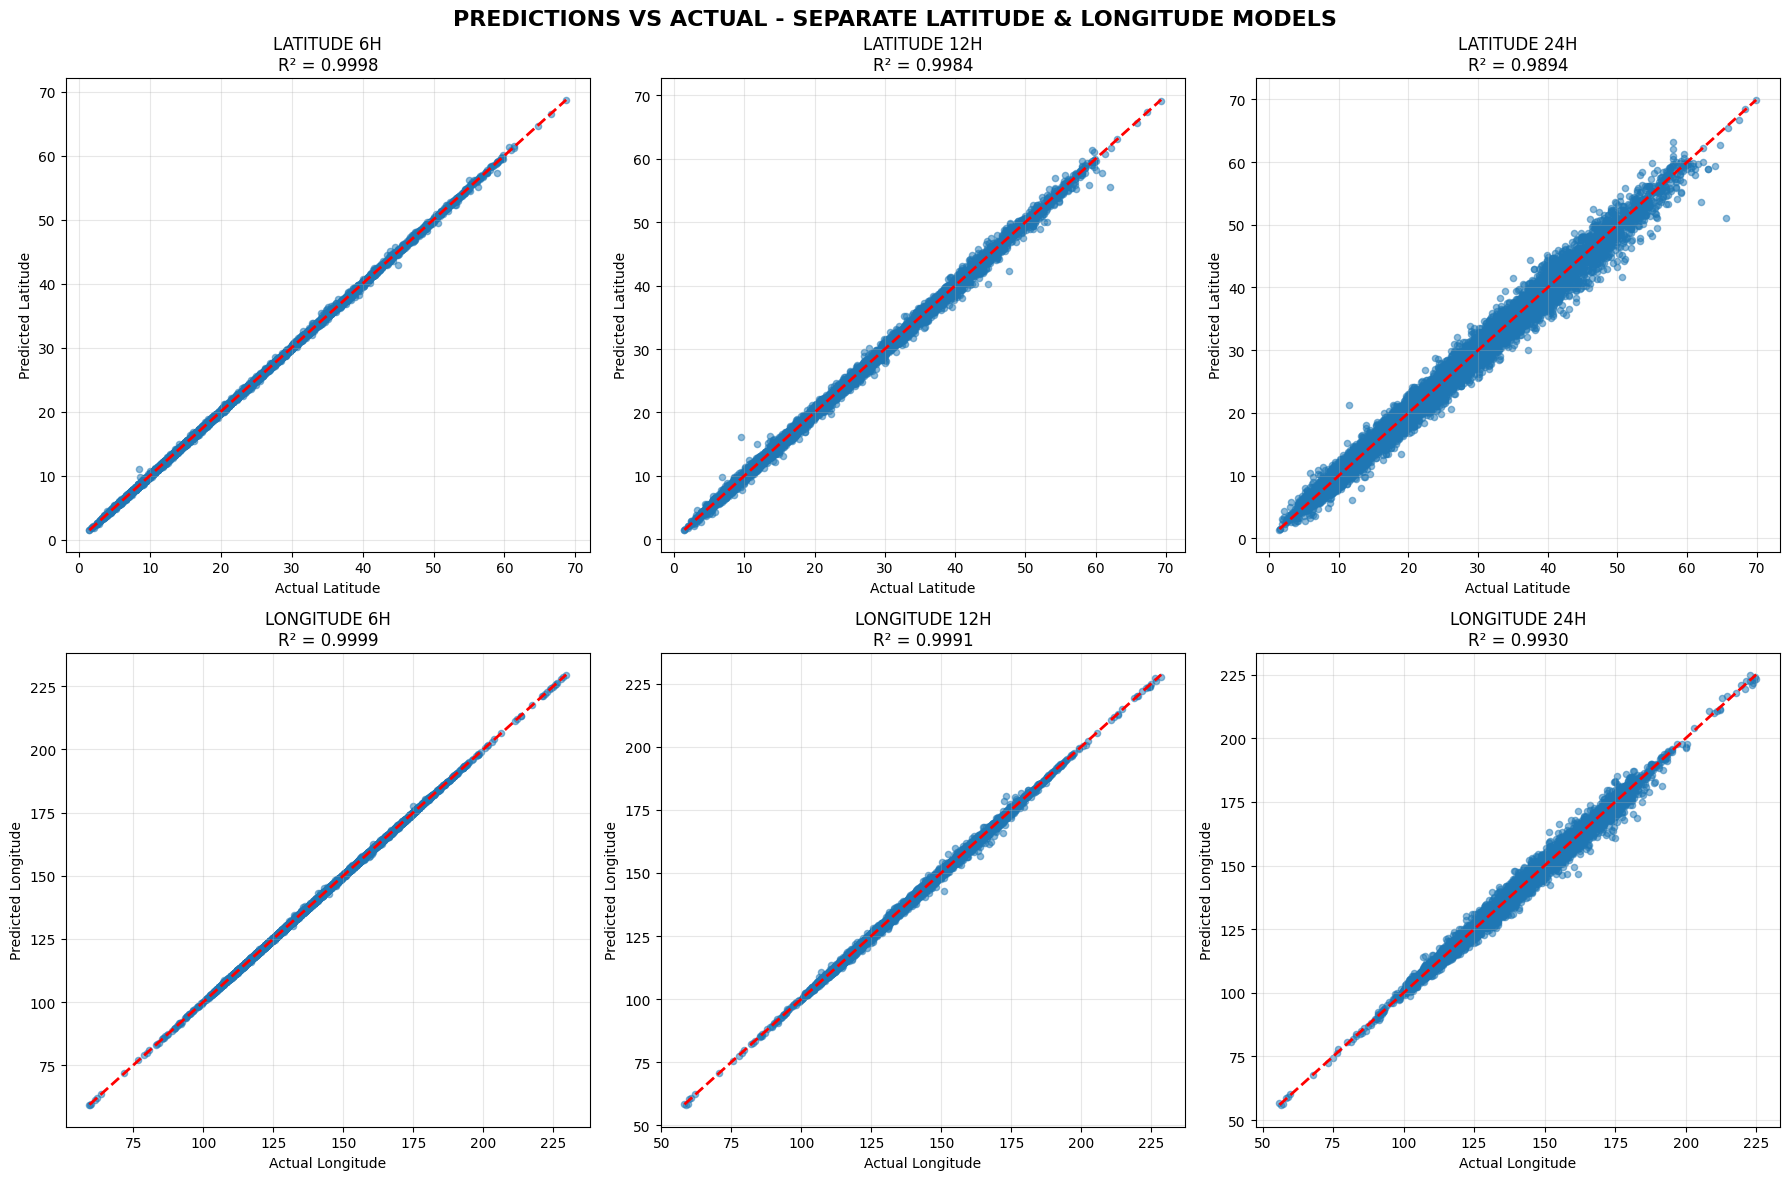

In [12]:
plot_predictions_comparison(lat_results, lon_results, horizons)

## VISUALIZATION - ERROR DISTRIBUTION

In [13]:
def plot_error_distribution(distance_errors):
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  fig.suptitle('DISTANCE ERROR DISTRIBUTION BY PREDICTION HORIZON', fontsize=16, fontweight='bold')

  for i, horizon in enumerate(horizons):
    ax = axes[i]
    
    # Calculate errors for this horizon
    lat_pred = lat_results[horizon]['predictions']
    lon_pred = lon_results[horizon]['predictions']
    lat_actual = lat_results[horizon]['test_actual']
    lon_actual = lon_results[horizon]['test_actual']
    
    def haversine(lat1, lon1, lat2, lon2):
      R = 6371
      lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
      dlat = lat2 - lat1
      dlon = lon2 - lon1
      a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
      return 2 * R * np.arcsin(np.sqrt(a))
    
    distances = []
    for j in range(len(lat_actual)):
      dist = haversine(lat_actual[j], lon_actual[j], lat_pred[j], lon_pred[j])
      distances.append(dist)
      
    # Plot histogram
    ax.hist(distances, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax.axvline(np.mean(distances), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(distances):.1f} km')
    ax.axvline(np.median(distances), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(distances):.1f} km')
    
    ax.set_xlabel('Distance Error (km)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{horizon} Prediction\n95th %ile: {np.percentile(distances, 95):.1f} km')
    ax.legend()
    ax.grid(True, alpha=0.3)
  
  plt.tight_layout()
  plt.show()

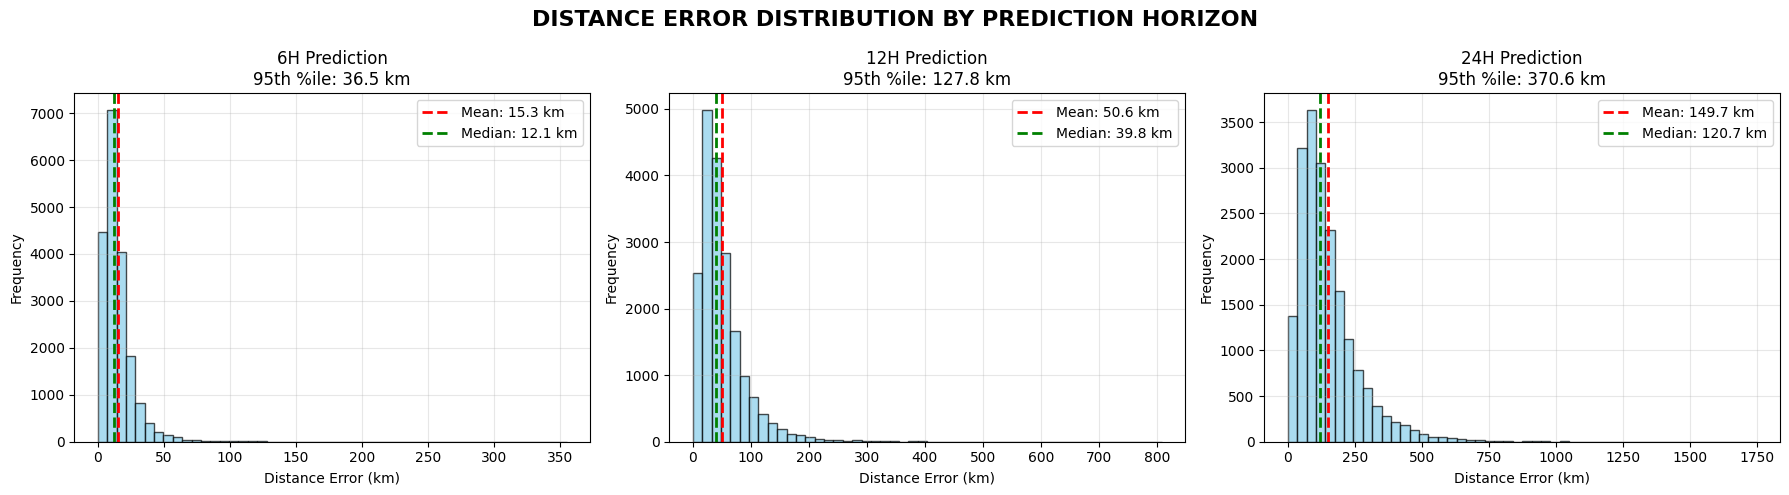

In [14]:
plot_error_distribution(distance_errors)

## MODEL SUMMARY

In [15]:
print('\nPERFORMANCE SUMMARY:')
for horizon in horizons:
  lat_rmse = lat_results[horizon]['rmse']
  lon_rmse = lon_results[horizon]['rmse']
  lat_r2 = lat_results[horizon]['r2']
  lon_r2 = lon_results[horizon]['r2']
  dist_error = distance_errors[horizon]['mean_km']
  
  print(f'\n{horizon} PREDICTION:')
  print(f'Latitude  - RMSE: {lat_rmse:.4f}, R²: {lat_r2:.4f}')
  print(f'Longitude - RMSE: {lon_rmse:.4f}, R²: {lon_r2:.4f}')
  print(f'Distance Error: {dist_error:.2f} km')

print('\nMODEL TRAINING COMPLETED SUCCESSFULLY!')


PERFORMANCE SUMMARY:

6H PREDICTION:
Latitude  - RMSE: 0.1273, R²: 0.9998
Longitude - RMSE: 0.1560, R²: 0.9999
Distance Error: 15.29 km

12H PREDICTION:
Latitude  - RMSE: 0.4058, R²: 0.9984
Longitude - RMSE: 0.5206, R²: 0.9991
Distance Error: 50.60 km

24H PREDICTION:
Latitude  - RMSE: 1.1149, R²: 0.9894
Longitude - RMSE: 1.5295, R²: 0.9930
Distance Error: 149.71 km

MODEL TRAINING COMPLETED SUCCESSFULLY!


## SAVE MODEL

In [16]:
import pickle
from datetime import datetime

In [17]:
model_package = {
  'lat_models': lat_models,
  'lon_models': lon_models,
  'lat_results': lat_results,
  'lon_results': lon_results,
  'distance_errors': distance_errors,
  'features': features,
  'encoded_features': encoded_features,
  'horizons': horizons,
  'training_info': {
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'samples_train': X_train.shape[0],
    'samples_test': X_test.shape[0],
    'performance_metrics': {
      '6H': {
        'lat_rmse': 0.1273, 'lat_r2': 0.9998,
        'lon_rmse': 0.1560, 'lon_r2': 0.9999,
        'distance_error': 15.29
      },
      '12H': {
        'lat_rmse': 0.4058, 'lat_r2': 0.9984,
        'lon_rmse': 0.5206, 'lon_r2': 0.9991,
        'distance_error': 50.60
      },
      '24H': {
        'lat_rmse': 1.1149, 'lat_r2': 0.9894,
        'lon_rmse': 1.5295, 'lon_r2': 0.9930,
        'distance_error': 149.71
      }
    }
  },
  'model_version': '1.0.0'
}

with open('../model/storm_prediction_models.pkt', 'wb') as f:
  pickle.dump(model_package, f)

print('Models saved successfully as storm_prediction_models.pkt!')

Models saved successfully as storm_prediction_models.pkt!
